# This notebook gives examples of measuring centroids and doing photometry, both with PhotUtils and Source Extractor.  It is designed as a demo, and will not be collected.

## Part 1: Calculating Centroids

In [1]:
import numpy as np
from astropy.convolution import AiryDisk2DKernel
import matplotlib.pyplot as plt

Let's define a source as an Airy Disk, and put it in a 101x101 pixel image.

We'll choose a "radius" of 5 pixels (this is the distance from the center to the first negative).

In [2]:
source=np.array(AiryDisk2DKernel(5,x_size=31,y_size=31))
source=source/np.sum(source)*1000.0  #Normalize the total flux of the source to 1000

image=np.zeros([101,101])
image[50:81,10:41]=source  #y,x, note y starts from top
image=image+1.0 #Lets add a sky background of 2 e-
image=np.random.poisson(image)  #Sample the image with Poisson noise
image=image+np.random.normal(0.0,1.0,[101,101])  #Add a read noise of 1 e-

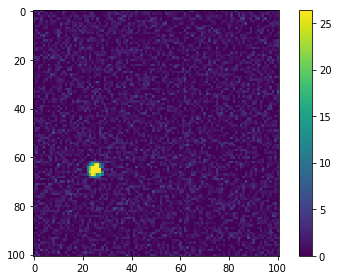

In [3]:
#Display the image
#Make sure the source looks like you expected

plt.figure()
plt.imshow(image,vmin=0,vmax=0.5*np.max(image))
plt.colorbar()
plt.tight_layout()

Lets first measure the centroids manually by calculating the marginalized distribution of the PSF on each axis.

This is the first set of equations on slide 4 of the lecture slides.

First, lets collapse in the y-direction to find the x centroid.

(We will sum over the full image since we only have one source, but if you had >1, you would have to narrow down the sum range to stick to the region near your source.)

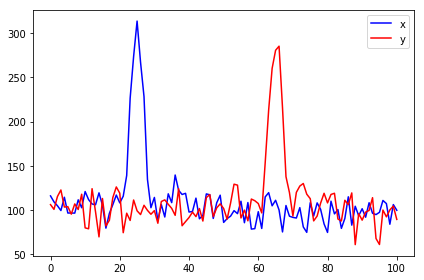

In [4]:
x_marg=np.zeros(101)  #Define an empty array to store our marginalized array
for i in range(101):  #Loop over the x pixels, summing all pixels in the y-direction
    x_marg[i]=np.sum(image[:,i])
#Then do the same in the y-direction
y_marg=np.zeros(101)
for j in range(101):
    y_marg[j]=np.sum(image[j,:])
    
#Make a plot to look at these marginalized distributions
plt.figure()
plt.plot(np.arange(101),x_marg,'blue',label='x')
plt.plot(np.arange(101),y_marg,'red',label='y')
plt.legend()
plt.tight_layout()

Ok, I see the peak in x is around 25, and in y is around 65.  
Is this what we would expect from how we defined the image?

### Now, lets try a more accurate calculation, which is the intensity weighted centroid.  
First, we need to calculate the mean intensity in each direction as the total of the marginalized distributions, divided by the number of pixels you're averaging over.  This is the second set of equations on slide 4 of the lecture slides.  
We'll make use of the x_marg and y_marg variables we calculated above, as they are the sums in the equations, which is the same for this calculation.

In [5]:
n_pix=(len(x_marg)-1.)/2.
x_mean=(1/(2*n_pix+1))*np.sum(x_marg)  
y_mean=(1/(2*n_pix+1))*np.sum(y_marg)  

Finally, calculate the intensity-weighted centroid.

In [6]:
xarr=np.arange(101) ; yarr=np.arange(101)  #Set up an integer array of x and y values
#Calculate the argument x(y)_marg-x(y)_mean, set minimum to zero
xsum=x_marg-x_mean ; xsum=xsum.clip(min=0)
ysum=y_marg-y_mean ; ysum=ysum.clip(min=0)

#Evaluate the intensity-weighted centroid
xcen=np.sum((xsum)*xarr)/np.sum((xsum))
ycen=np.sum((ysum)*yarr)/np.sum((ysum))

#Print the x and y centers, and compare to your plot above - do they look right?  If not, why not?
print(xcen,ycen)

26.689917728020824 61.29269692749061


Measure centroids using three different canned routines, verify they agree with manual. You may need to pip install photutils. You can ignore the deprecation warnings.

In [11]:
from photutils import centroid_com, centroid_1dg, centroid_2dg

In [12]:
x, y = centroid_com(image)    #This is the moment distribution, like we did above
x2, y2 = centroid_1dg(image)  #This fits a Gaussian separtely in the x and y directions
x3, y3 = centroid_2dg(image)  #This fits a 2D Gaussian to the full image

#Print all three values; do they agree with your calculated version?
print(x,y)
print(x2,y2)
print(x3,y3)

46.98991939898565 50.968567293210505
24.96760104694069 65.06083285736804
25.378198021841193 65.36566565744633


## Part 2: Aperture Photometry

In [13]:
#Perform aperture photometry at the position calculated above

from photutils import CircularAperture
from photutils import aperture_photometry

In [14]:
positions = (x3,y3) #Set the centroid of our source using the most accurate value from above
apertures = CircularAperture(positions, r=5.)  #Use an aperture with r=5 pixels (~FWHM)

phot_table = aperture_photometry(image, apertures) #Do the actual aperture photometry
print(phot_table) 


 id      xcenter            ycenter         aperture_sum  
           pix                pix                         
--- ------------------ ----------------- -----------------
  1 25.378198021841193 65.36566565744633 925.8774386166887


This prints our results, showing the source number, x and y position, and the photometry measure.

If we wanted just the actual photometric value, this is stored in: phot_table['aperture_sum']

In [15]:
#Perform photometry in annulus around the position above
from photutils import CircularAnnulus

In [16]:
#First, define an annulus - r_in and r_out set position of annulus
annulus_apertures = CircularAnnulus(positions, r_in=8., r_out=10.)
#Measure the flux in the annulus
annulus_table = aperture_photometry(image, annulus_apertures)
print(annulus_table)

 id      xcenter            ycenter         aperture_sum   
           pix                pix                          
--- ------------------ ----------------- ------------------
  1 25.378198021841193 65.36566565744633 102.72084241057036


Efficiency tool - we can actually measure thre flux in our aperture and in the annulus at the same time

In [17]:

apers=[apertures,annulus_apertures]  #Define a list of apertures; first is science, second is background annulus
final_table = aperture_photometry(image, apers)
print(final_table)


 id      xcenter            ycenter        aperture_sum_0    aperture_sum_1  
           pix                pix                                            
--- ------------------ ----------------- ----------------- ------------------
  1 25.378198021841193 65.36566565744633 925.8774386166887 102.72084241057036


Now, final_table['aperture_sum_0'] is the flux of our source of interest, and
    final_table['aperture_sum_1'] is the *total* flux in our annulus.
    
Finally, to get the flux of our source, we need to calculate the background per pixel, and subtract it.

Background in counts/pix=annulus flux divided by npix in annulus - we can use the attribute "area", i.e. annulus_apertures.area()

In [34]:
bkg_mean = final_table['aperture_sum_1'][0] / annulus_apertures.area
bkg_sum = bkg_mean * apertures.area  #Total background in our science aperture
final_sum = final_table['aperture_sum_0'][0] - bkg_sum  #Do background subtraction
final_table['Final_aperture_flux'] = final_sum  #Add column to table with this final flux
print(final_table)

 id      xcenter       ...   aperture_sum_1   Final_aperture_flux
           pix         ...                                       
--- ------------------ ... ------------------ -------------------
  1 25.378198021841193 ... 102.72084241057036   854.5435202760148


final_table['Final_aperture_flux'] is our final flux measurement, which can be used for science.

## Part 3: Source Extractor
### In class, we showed how to take a reduced 30" CCD image, add world coordinate system (WCS) to the header via astrometry.net, and how to make a catalog with Source Extractor.  Here, we will read in this catalog, and figure out how to calculate the fluxes of objects in physical units (e.g., erg/s/cm2/Hz), which requires calculating a magnitude zeropoint.

In [19]:
#Read in catalog - ascii automagically figures out its a Source Extractor Catalog
from astropy.io import ascii
cat=ascii.read('qatar1_r.cat')

In [20]:
#View the catalog
cat

NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,FLUX_ISO,FLUXERR_ISO,ISOAREA_IMAGE,FLUX_APER,FLUXERR_APER,FLUX_AUTO,FLUXERR_AUTO,KRON_RADIUS,A_IMAGE,B_IMAGE,THETA_IMAGE,ELLIPTICITY,FWHM_IMAGE,FLUX_RADIUS,BACKGROUND,FLAGS,CLASS_STAR
,pix,pix,deg,deg,ct,ct,pix2,ct,ct,ct,ct,,pix,pix,deg,,pix,pix,ct,,
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
1,1.2853,768.425,302.4073781,65.1124196,422270.0,1113.417,907,2883.229,84.08704,446909.1,1490.862,3.5,203.975,1.36,-89.94,0.993,100.0,141.675,603.6922,27,0.029
2,1.1896,347.967,302.4000256,65.2705996,339769.7,892.2683,608,5631.074,91.96413,473993.9,1021.025,3.5,142.635,0.699,-89.91,0.995,59.95,143.262,610.9043,27,0.177
3,1182.3771,58.5312,303.461727,65.3845445,916942.7,894.3227,404,500769.4,648.9485,903538.4,813.6443,3.5,2.231,2.112,-30.0,0.054,4.05,1.85,623.8774,6,0.992
4,378.265,26.4324,302.7350575,65.3939962,938473.2,917.4786,482,474823.8,645.2365,922733.2,821.6487,3.5,2.553,2.125,-37.87,0.168,5.34,1.967,618.3906,4,0.972
5,1466.1002,30.5292,303.7180409,65.3951753,99773.27,376.766,144,63339.33,236.1302,98468.4,360.3411,3.5,2.21,1.801,-16.74,0.185,2.54,1.577,624.3596,3,0.977
6,1461.2637,21.1647,303.7136831,65.398701,39487.52,277.6885,92,25045.84,160.3895,39389.14,292.7624,3.5,1.934,1.778,-10.11,0.081,2.6,1.557,624.4573,3,0.874
7,275.3589,28.3627,302.6421128,65.3926821,83754.1,350.3391,134,51943.54,215.8822,82927.89,338.6184,3.5,2.043,1.82,-0.91,0.109,2.82,1.61,615.5851,0,0.942
8,295.0296,26.7663,302.6598617,65.3933995,53957.68,287.3452,85,34134.9,183.487,53857.36,301.1761,3.5,1.915,1.682,-26.62,0.122,2.5,1.581,616.5012,0,0.98


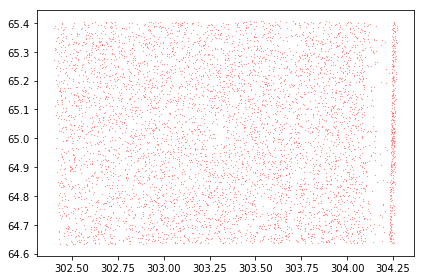

In [21]:
#Examine the spatial distribution of my detected sources.  Any obvious problem?
ra=np.array(cat['ALPHA_J2000'])
dec=np.array(cat['DELTA_J2000'])
plt.figure()
plt.scatter(ra,dec,c='red',marker='.',s=0.1)
plt.tight_layout()

Let's check out a magnitude histogram, using FLUX_AUTO, which is the flux in counts measured in the MAG_AUTO elliptical aperture.

Before turning into a magnitude, we need to search for negative flux values, which will cause problems since magnitude is on a log scale (negative pixels are just noise anyway).
    
    
I set them to tiny tiny numbers, which will make a large magnitude, easily flagged later.

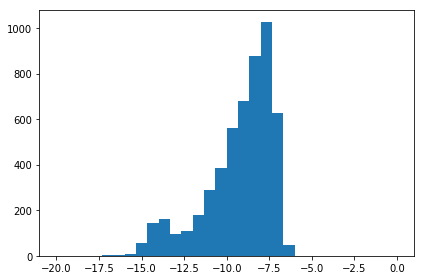

In [22]:
flux=np.array(cat['FLUX_AUTO'])

g=np.where(flux < 0.0) ; flux[g]=1e-30
mag=(-2.5)*np.log10(flux)
plt.figure()
plt.hist(mag,bins=30,range=[-20,0])
plt.tight_layout(); plt.show(); plt.close()
#This histogram shows our object's *instrumental* magnitudes

We need to find a zeropoint for our image.  To do this, lets match to the PAN-STAARS r-band

In [24]:
#Import some stuff - you may need to pip install astroquery
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier
from astropy.utils.console import ProgressBar

In [25]:
#Define the columns I would like to get back from Vizier
v = Vizier(columns=['RAJ2000', 'DEJ2000','umag', 'gmag', 'rmag','imag'])

I need to do this in a loop, over each object in my catalog.
This would take forever, so lets just do the first 200 objects.

In [26]:

ps_rmag=np.zeros(len(ra)) # An empty array to fill with the PS (Pan-STAARS) r-band magnitude for my 200 objects
n=200 #or len(ra) for full catalog

for i in range(n):
    pos = SkyCoord(ra[i]*u.deg,dec[i]*u.deg,frame='icrs') #Make a SkyCoord object for index i of my list of 200 stars
    result=v.query_region(pos,width="60s",catalog='panstaars')  #Query Vizier for sources within 60 arcsec of this position
    #At this point, I have a lot of sources, since many will be within 60"
    #I only want the closest one, so I need to measure the angular distance
    dist=np.zeros(len(result[0]['rmag']))  #Set up an empty distance array
    tra=np.array(result[0]['RAJ2000'])  #Make a variable for the PS RA
    tdec=np.array(result[0]['DEJ2000'])  #Make a variable for the PS Dec
    for j in range(len(dist)): #Run a loop over the PS objects to measure the distance
        tobj=SkyCoord(tra[j]*u.deg,tdec[j]*u.deg,frame='icrs')
        dist[j]=tobj.separation(pos).arcsec
    #Now I have the measured distances.  I want the closest one, but only if its close enough I'm sure its the same object
    #I'll be a little liberal, and assume I've found the closest one if its at < 10"
    g=np.where((dist <= 10.0) & (dist==np.min(dist)))
    if len(g[0]) > 0: #If there is a match within 10", then put the PS r-band magnitude in my array
        ps_rmag[i]=float(result[0]['rmag'][g])
    else: #If there is no match, set the mag to some crazy value nowhere near a real value
        ps_rmag[i]=-99
#This will throw some warnings; its ok

/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.


/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


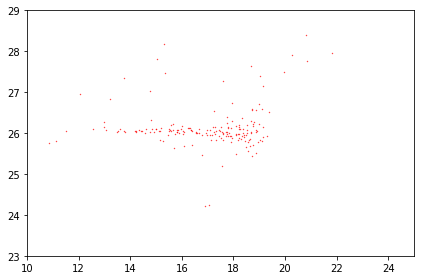

In [27]:
#Now lets compare the PS r-band magnitudes to our instrumental magnitudes
g=np.where(ps_rmag > 0)  #Only consider objects where I found a match
plt.figure()
plt.scatter(ps_rmag[g],ps_rmag[g]-mag[g],c='red',marker='.',s=0.5)
plt.xlim(10,25)
plt.ylim(23,29)
plt.tight_layout()

We see a pretty good correlation!
The median of the y-axis value is then our zeropoint!
To make sure we only use pretty good values to calculate that zeropoint, let's
calculate the median in a box surrounding the nice sequence.

/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


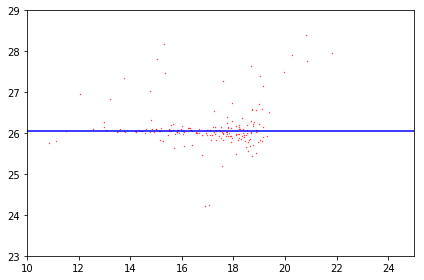

In [28]:

g2=np.where((ps_rmag > 14) & (ps_rmag < 17.5) & ((ps_rmag-mag) >= 25.5) & ((ps_rmag-mag) <= 26.5))

zp=np.nanmedian(ps_rmag[g2]-mag[g2])
plt.figure()
plt.scatter(ps_rmag[g],ps_rmag[g]-mag[g],c='red',marker='.',s=0.5)
plt.axhline(y=zp, color='b', linestyle='-')
plt.xlim(10,25)
plt.ylim(23,29)
plt.tight_layout()

The blue line shows our zeropoint, pretty good!
Let's print the value

In [29]:
zp

26.048302202525242

## We can now obtain fluxes in cgs units for our sources.  We have two equations which define AB magnitude:

$$m_{\rm AB} = (-2.5)*\rm log_{10}(flux [counts]) + ZP$$
##### and
$$ m_{\rm AB} = (-2.5)*\rm log_{10}(flux [cgs]) - 48.6 $$


##### where "m_ab" is the AB magnitude, flux[counts] is the flux measured from the image, ZP is the zeropoint we measured above, and flux[cgs] is the quantity we want - the flux density in units of erg/s/cm2/Hz
##### Solve these two equations to obtain flux[cgs] in units of flux[counts], and you should get something like what is in the cell below

In [30]:
#Calculate the flux in cgs units in the r-band (I'll call this fnu)
fnu=np.array(cat['FLUX_AUTO'])*10.**(-0.4*48.6 - 0.4*zp)

/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/aec3675/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aec3675/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


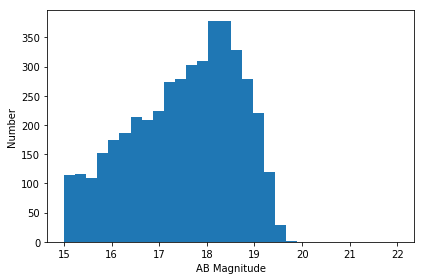

In [31]:
#Lets plot a histogram of our AB magnitudes, and see how it looks
m_ab=(-2.5)*np.log10(fnu)-48.6

#This will throw a warning due to log(negative number), but thats ok for this plotting purpose
plt.figure()
plt.hist(m_ab,bins=30,range=[15,22])
plt.xlabel('AB Magnitude') ; plt.ylabel('Number')
plt.tight_layout()